In [1]:
#James Alfano
import pandas as pd
import datasets
import sys
import numpy as np
from Preprocessing import *
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

## Reading in the Data

In [2]:
## load the full dataset of 300k articles
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

Found cached dataset cnn_dailymail (C:/Users/James/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [4]:
#Read in Training
lst_dics = [dic for dic in dataset["train"]]
train = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
train.head(5)

,text,y,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [5]:
#Read in testing
lst_dics = [dic for dic in dataset["test"]]
test = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
test.head()

,text,y,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
2,"(CNN)If you've been following the news lately,...",Mohammad Javad Zarif has spent more time with ...,4495ba8f3a340d97a9df1476f8a35502bcce1f69
3,(CNN)Five Americans who were monitored for thr...,17 Americans were exposed to the Ebola virus w...,a38e72fed88684ec8d60dd5856282e999dc8c0ca
4,(CNN)A Duke student has admitted to hanging a ...,Student is no longer on Duke University campus...,c27cf1b136cc270023de959e7ab24638021bc43f


In [6]:
#Read in Validation
lst_dics = [dic for dic in dataset["validation"]]
validation = pd.DataFrame(lst_dics).rename(columns={"article":"text", 
      "highlights":"y","id":"id"})[["text","y","id"]]
validation.head()

,text,y,id
0,"(CNN)Share, and your gift will be multiplied. ...",Zully Broussard decided to give a kidney to a ...,a4942dd663020ca54575471657a0af38d82897d6
1,"(CNN)On the 6th of April 1996, San Jose Clash ...",The 20th MLS season begins this weekend .\nLea...,4157bc4da185971e2742f349d69a037343bc0d95
2,"(CNN)French striker Bafetimbi Gomis, who has a...",Bafetimbi Gomis collapses within 10 minutes of...,60736693e3b1b32d14337a317190c6606e879a85
3,(CNN)It was an act of frustration perhaps more...,Rory McIlroy throws club into water at WGC Cad...,8cdf9cc3ed0276b7a7944cc18ba459355b5984ad
4,(CNN)A Pennsylvania community is pulling toget...,"Cayman Naib, 13, hasn't been heard from since ...",2e6613d531843515bf5401286cc3e45c4df530d2


In [7]:
print(train.shape)
print(test.shape)
print(validation.shape)


(287113, 3)
(11490, 3)
(13368, 3)


In [8]:
print(train.iloc[0,0])

LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how

In [9]:
print(train.iloc[0,1])

Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday .
Young actor says he has no plans to fritter his cash away .
Radcliffe's earnings from first five Potter films have been held in trust fund .


## Preprocessing 

In [10]:
#take a subset of the training data
subset_train = train.iloc[0:15000,0:15000]
subset_test = test.iloc[0:10000,0:10000]
subset_valid = validation.iloc[0:10000,0:10000]


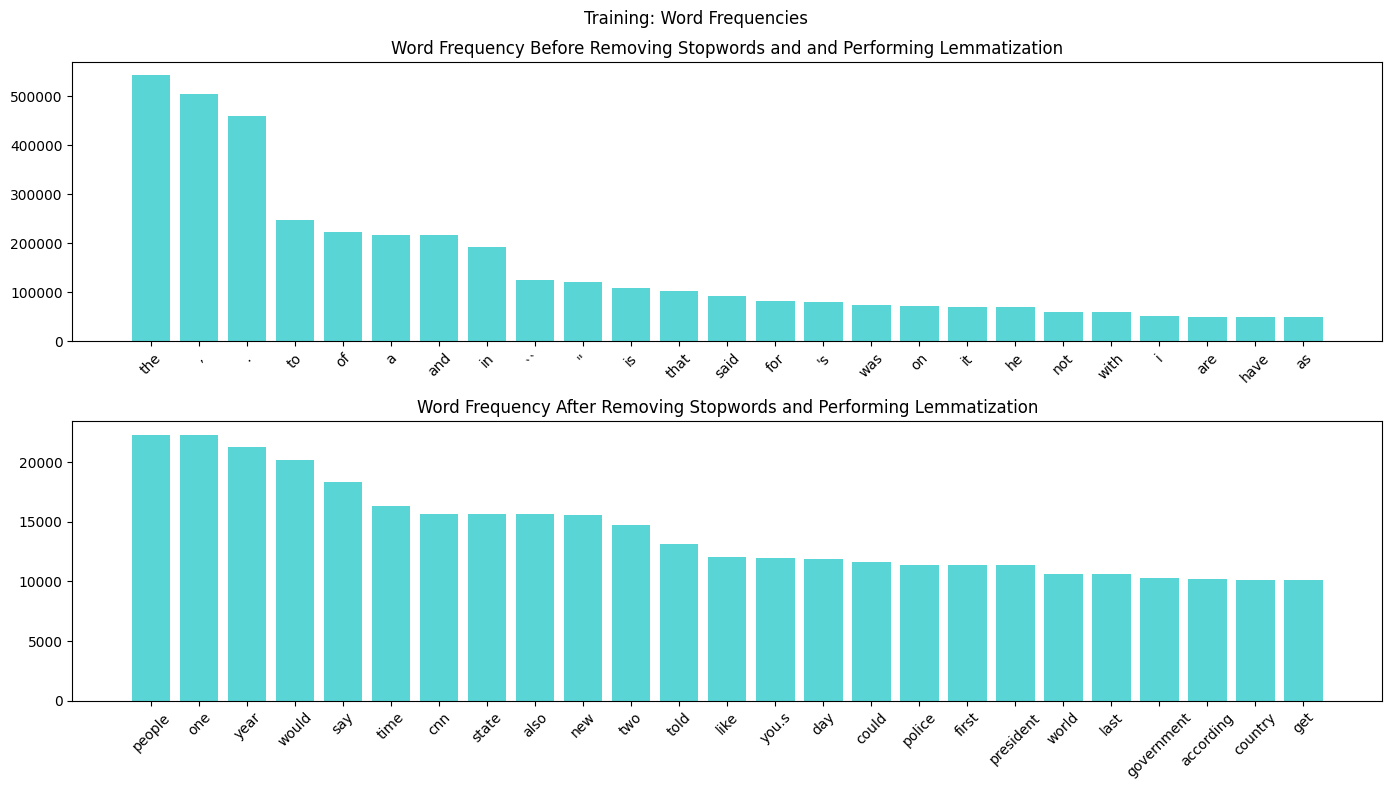

In [11]:
preprocess(subset_train,"Training",1)

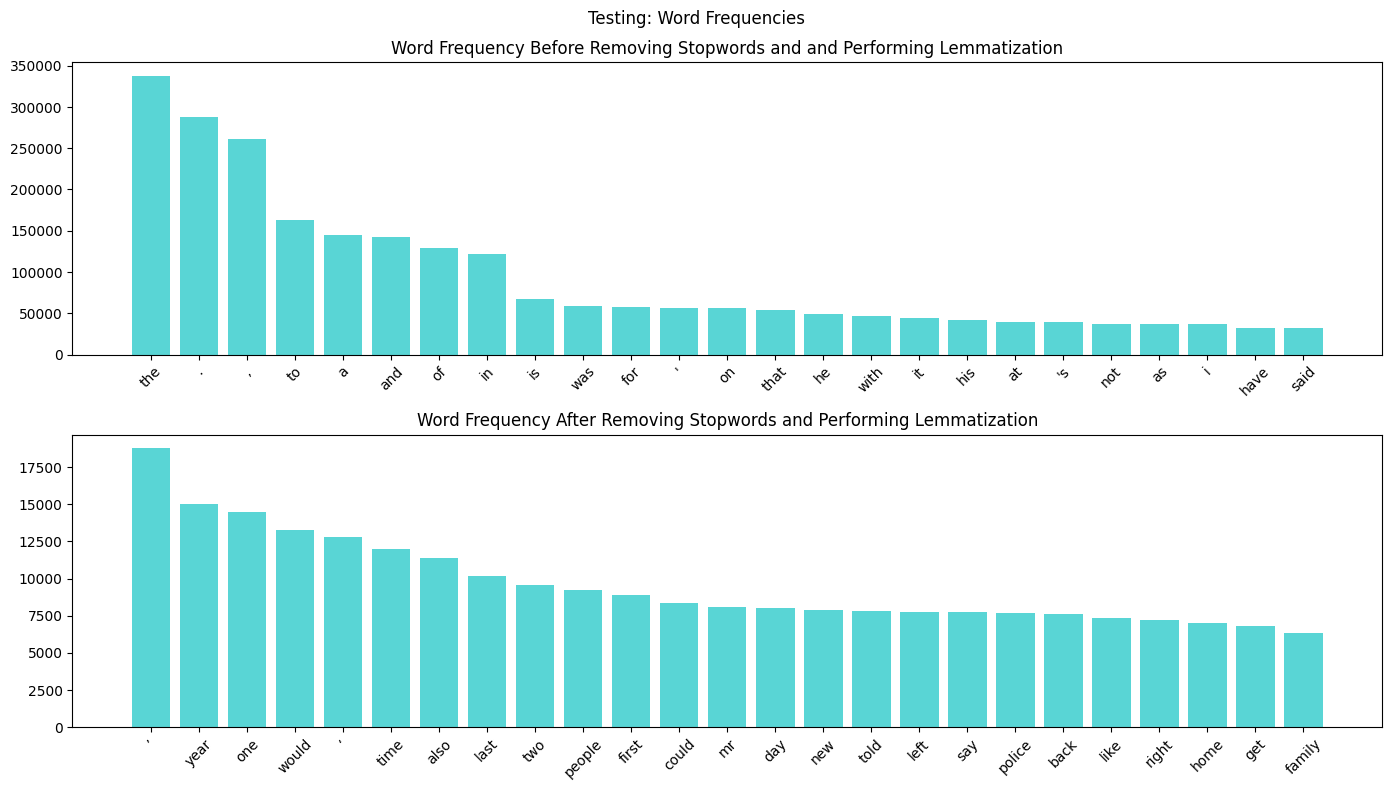

In [12]:
preprocess(subset_test,"Testing",1)

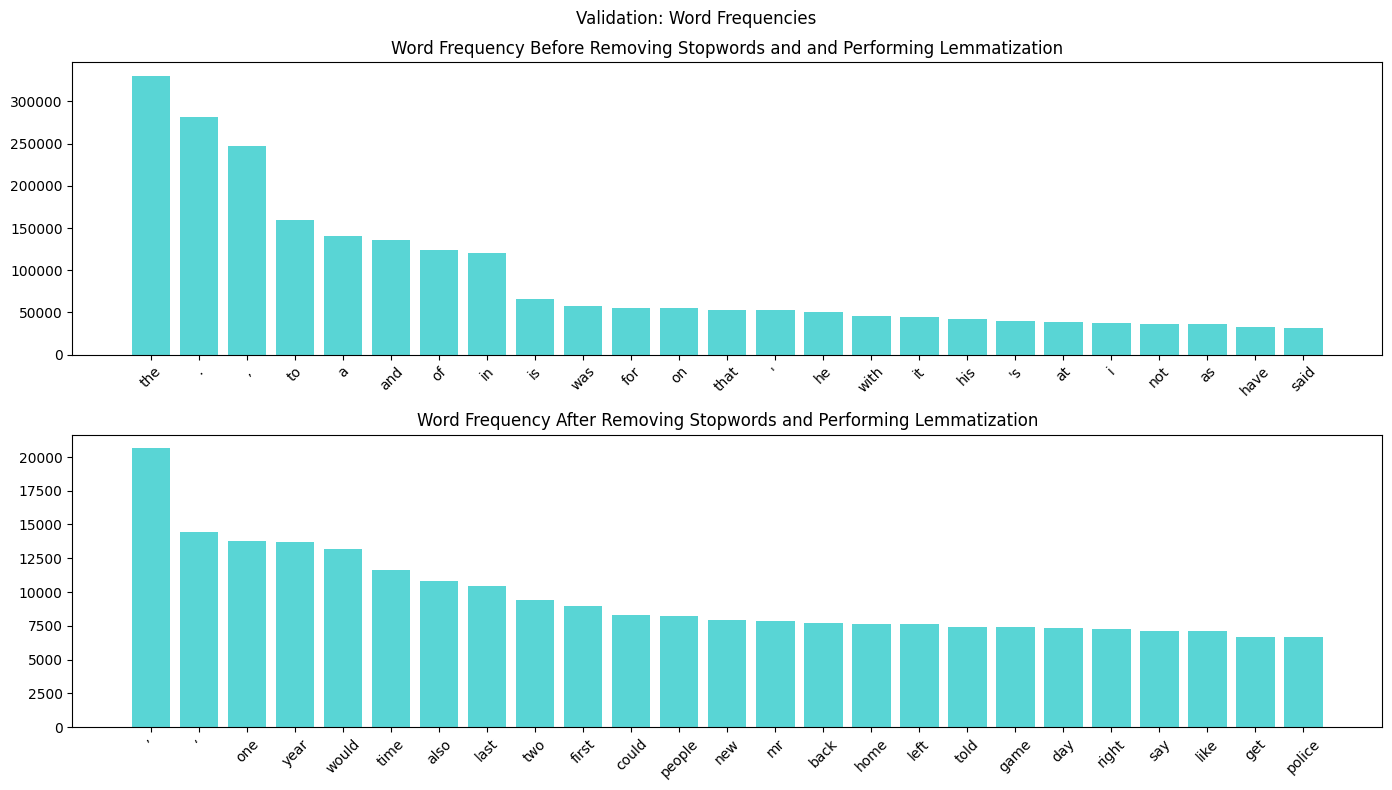

In [13]:
preprocess(subset_valid,"Validation",1)

In [14]:
#Run Function to get the average word count and list of counts for all articles and summaries 
avg_y, counts_y = avg_num_words(subset_train["y"])
avg_text, counts_text = avg_num_words(subset_train["text"])

The longest summary has 53 words
The longest article has 1295 words


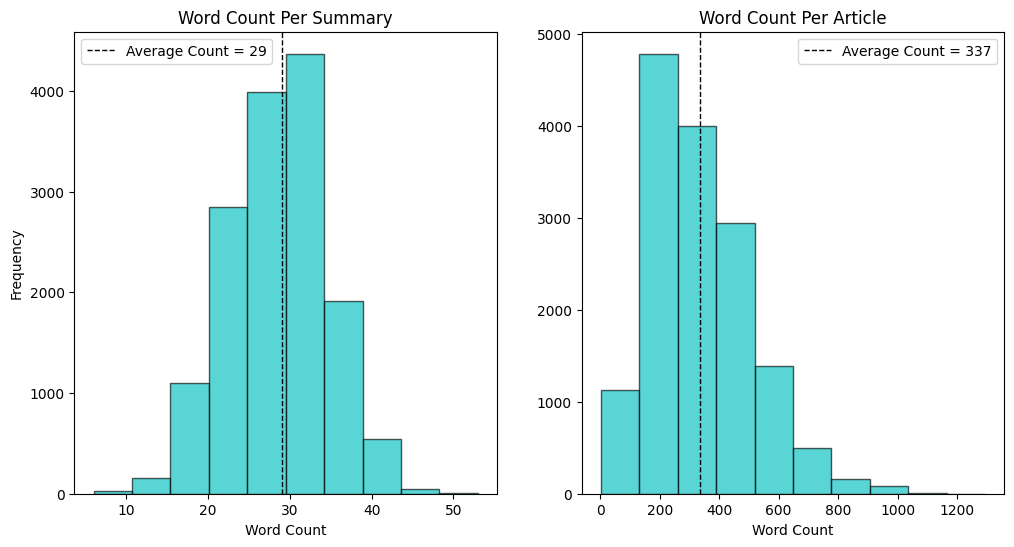

In [15]:
plot_counts(subset_train)

In [16]:
print(subset_valid.iloc[0,1])

['zully', 'broussard', 'decided', 'give', 'kidney', 'stranger', 'new', 'computer', 'program', 'helped', 'donation', 'spur', 'transplant', 'six', 'kidney', 'patient']


In [17]:
print(subset_valid.iloc[0,0])

['cipient', 'pair', 'work', 'simple', 'swapping', 'principle', 'take', 'much', 'higher', 'level', 'according', 'california', 'pacific', 'medical', 'center', 'san', 'francisco', 'high', 'taking', 'five', 'surgeon', 'covey', 'physician', 'assistant', 'nurse', 'anesthesiologist', '40', 'support', 'staff', 'perform', 'surgery', '12', 'people', 'extracting', 'six', 'kidney', 'donor', 'implanting', 'six', 'recipient', 'age', 'donor', 'recipient', 'range', '26', '70', 'include', 'three', 'parent', 'child', 'pair', 'one', 'sibling', 'pair', 'one', 'brother', 'sister-in-law', 'pair', 'medical', 'center', 'statement', 'chain', 'surgery', 'wrapped', 'friday', 'late', 'march', 'medical', 'center', 'planning', 'hold', 'reception', '12', 'patient', 'super', 'swap', 'work', 'according', 'california', 'pacific', 'medical', 'center', 'say', 'brother', 'need', 'kidney', 'save', 'life', 'least', 'get', 'dialysis', 'willing', 'give', 'one', 'turn', 'kidney', 'match', 'certain', 'body', 'would', 'reject', 

In [18]:
dataset = combine_data(subset_train,subset_test,subset_valid)

In [19]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 10000
    })
})

In [20]:
dataset["train"]["article"][0]

"harry potter star daniel radcliffe gain access reported £20 million 41.1 million fortune turn 18 monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party plan one people soon turn 18 suddenly buy massive sport car collection something similar told australian interviewer earlier month think particularly extravagant thing like buying thing cost 10 pound book cd dvd 18 radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six place number one movie uk box office chart detail mark landmark birthday wrap agent publicist comment plan definitely sort party interview hopefully none reading radcliffe earnings first five potter film held trust fund able touch despite growing fame rich actor say keeping foot firmly ground people always looking say 'kid star go rail told reporter last month try hard go way would easy lates

In [21]:
subset_train["text"][0]

"harry potter star daniel radcliffe gain access reported £20 million 41.1 million fortune turn 18 monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party plan one people soon turn 18 suddenly buy massive sport car collection something similar told australian interviewer earlier month think particularly extravagant thing like buying thing cost 10 pound book cd dvd 18 radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six place number one movie uk box office chart detail mark landmark birthday wrap agent publicist comment plan definitely sort party interview hopefully none reading radcliffe earnings first five potter film held trust fund able touch despite growing fame rich actor say keeping foot firmly ground people always looking say 'kid star go rail told reporter last month try hard go way would easy lates

## Building the Model

In [22]:
import transformers
import torch
from huggingface_hub import notebook_login
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer
#! pip install datasets transformers rouge-score nltk

metric = load_metric("rouge")
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

C:\Users\James\AppData\Local\Temp\ipykernel_19936\4046035904.py:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")
c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\models\t5\tokenization_t5_fast.py:156: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantia

In [23]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "summarize: "
else:
    prefix = ""

max_input_length = max(counts_text)
max_target_length = max(counts_y)

def prepare_for_model(examples):
    inputs = [prefix + doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["highlights"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [24]:
tokenized_datasets = dataset.map(prepare_for_model, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:3546: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [25]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 15000
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
})

In [26]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [27]:
batch_size = 4
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-cnn-articles",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    push_to_hub=False,
)

In [28]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [29]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [30]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using cuda_amp half precision backend


In [31]:
trainer.train()
trainer.save_model()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, highlights, article. If id, highlights, article are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
c:\Users\James\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 15000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
  Number of trainable parameters = 60506624


  0%|          | 0/3750 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-500\config.json


{'loss': 3.1716, 'learning_rate': 1.735466666666667e-05, 'epoch': 0.13}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-1000
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-1000\config.json


{'loss': 3.0662, 'learning_rate': 1.4688000000000002e-05, 'epoch': 0.27}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-1000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-1000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-2000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-1500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-1500\config.json


{'loss': 2.9667, 'learning_rate': 1.2021333333333333e-05, 'epoch': 0.4}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-1500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-1500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-2500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-2000
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-2000\config.json


{'loss': 2.9485, 'learning_rate': 9.354666666666667e-06, 'epoch': 0.53}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-2000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-2000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-2000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-2500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-2500\config.json


{'loss': 2.9326, 'learning_rate': 6.688e-06, 'epoch': 0.67}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-2500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-2500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-2500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-1000] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-3000
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-3000\config.json


{'loss': 2.9114, 'learning_rate': 4.021333333333333e-06, 'epoch': 0.8}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-3000\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-3000\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-3000\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-1500] due to args.save_total_limit
Saving model checkpoint to t5-small-finetuned-cnn-articles\checkpoint-3500
Configuration saved in t5-small-finetuned-cnn-articles\checkpoint-3500\config.json


{'loss': 2.9256, 'learning_rate': 1.354666666666667e-06, 'epoch': 0.93}


Model weights saved in t5-small-finetuned-cnn-articles\checkpoint-3500\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\checkpoint-3500\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\checkpoint-3500\special_tokens_map.json
Deleting older checkpoint [t5-small-finetuned-cnn-articles\checkpoint-2000] due to args.save_total_limit
The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: id, highlights, article. If id, highlights, article are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 4


  0%|          | 0/2500 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to t5-small-finetuned-cnn-articles
Configuration saved in t5-small-finetuned-cnn-articles\config.json


{'eval_loss': 2.973193645477295, 'eval_rouge1': 21.3904, 'eval_rouge2': 8.6629, 'eval_rougeL': 17.8802, 'eval_rougeLsum': 17.8915, 'eval_gen_len': 18.963, 'eval_runtime': 835.1743, 'eval_samples_per_second': 11.974, 'eval_steps_per_second': 2.993, 'epoch': 1.0}
{'train_runtime': 1909.1826, 'train_samples_per_second': 7.857, 'train_steps_per_second': 1.964, 'train_loss': 2.980718343098958, 'epoch': 1.0}


Model weights saved in t5-small-finetuned-cnn-articles\pytorch_model.bin
tokenizer config file saved in t5-small-finetuned-cnn-articles\tokenizer_config.json
Special tokens file saved in t5-small-finetuned-cnn-articles\special_tokens_map.json


In [36]:

#document = 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - but it is almost like we\'re neglected or forgotten," she said.\n"That may not be true but it is perhaps my perspective over the last few days.\n"Why were you not ready to help us a bit more when the warning and the alarm alerts had gone out?"\nMeanwhile, a flood alert remains in place across the Borders because of the constant rain.\nPeebles was badly hit by problems, sparking calls to introduce more defences in the area.\nScottish Borders Council has put a list on its website of the roads worst affected and drivers have been urged not to ignore closure signs.\nThe Labour Party\'s deputy Scottish leader Alex Rowley was in Hawick on Monday to see the situation first hand.\nHe said it was important to get the flood protection plan right but backed calls to speed up the process.\n"I was quite taken aback by the amount of damage that has been done," he said.\n"Obviously it is heart-breaking for people who have been forced out of their homes and the impact on businesses."\nHe said it was important that "immediate steps" were taken to protect the areas most vulnerable and a clear timetable put in place for flood prevention plans.\nHave you been affected by flooding in Dumfries and Galloway or the Borders? Tell us about your experience of the situation and how it was handled. Email us on selkirk.news@bbc.co.uk or dumfries@bbc.co.uk.'
document = test.iloc[0,0]
if 't5' in model_name: 
    document = "summarize: " + document


from transformers import pipeline
model_name = "t5-small-finetuned-cnn-articles"
summarizer = pipeline('text2text-generation', model_name, framework="pt")

summarizer(document, max_length=128)

loading configuration file t5-small-finetuned-cnn-articles\config.json
Model config T5Config {
  "_name_or_path": "t5-small-finetuned-cnn-articles",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 6,
  "num_heads": 8,
  "num_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "transla

[{'generated_text': 'the 123rd member of the international criminal court is a step that gives the court jurisdiction over alleged crimes in the occupied Palestinian territory . the ICC opened a preliminary examination into the situation in the occupied territories .'}]

In [38]:
test.iloc[0,1]

'Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .\nIsrael and the United States opposed the move, which could open the door to war crimes investigations against Israelis .'

In [ ]:
import torch
torch.cuda.empty_cache()